# Radar DataTree: Accessing NEXRAD KLOT Data from Cloud Storage

This notebook demonstrates how to access and analyze weather radar data stored in the **Analysis-Ready Cloud-Optimized (ARCO)** format using the **Radar DataTree** framework.

## What is Radar DataTree?

Radar DataTree is a FAIR-compliant framework that transforms operational radar archives into cloud-optimized datasets. Key benefits include:

- **Time-indexed collections**: Entire radar archives organized as hierarchical, time-indexed datasets
- **Cloud-native access**: Zarr serialization optimized for parallel I/O and lazy evaluation
- **Sub-second data access**: Load metadata for ~92 GB of radar data in ~1.5 seconds
- **No file downloads required**: Stream data directly from cloud storage

## Data Source

This example uses **NEXRAD KLOT** (Chicago, IL) radar data hosted on the **Open Storage Network (OSN)**:
- Bucket: `nexrad-arco`
- Prefix: `KLOT-RT`
- Endpoint: `https://umn1.osn.mghpcc.org`

The data is stored using **Icechunk**, which provides ACID-compliant transactional storage with version control.

## Citation

If you use this data or framework, please cite:

> Ladino-Rincón & Nesbitt (2025). *Radar DataTree: A FAIR and Cloud-Native Framework for Scalable Weather Radar Archives*. arXiv:2510.24943 [cs.DC]. https://doi.org/10.48550/arXiv.2510.24943

## Setup

First, let's import the required libraries.

In [1]:
import xarray as xr
import icechunk as ic
import cmweather  # Radar colormaps
import icechunk
import xradar as xd
import demo_functions as dmf

## Configure Icechunk Repository

Icechunk manages large, versioned datasets stored on cloud object storage. The configuration below optimizes manifest loading for radar time-series data:

- **Manifest splitting**: Splits manifests by time dimension for efficient partial reads
- **Preloading**: Pre-loads coordinate arrays (vcp_time, azimuth, range) for fast metadata access

In [2]:
def get_repo_config():
    """Configure Icechunk repository for optimal radar data access."""
    split_config = icechunk.ManifestSplittingConfig.from_dict(
        {
            icechunk.ManifestSplitCondition.AnyArray(): {
                icechunk.ManifestSplitDimCondition.DimensionName("vcp_time"): 12
                * 24
                * 365  # roughly one year of radar data
            }
        }
    )
    var_condition = icechunk.ManifestPreloadCondition.name_matches(
        r"^(vcp_time|azimuth|range)$"
    )
    size_condition = icechunk.ManifestPreloadCondition.num_refs(0, 10_000)

    preload_if = icechunk.ManifestPreloadCondition.and_conditions(
        [var_condition, size_condition]
    )

    preload_config = icechunk.ManifestPreloadConfig(
        max_total_refs=10_000,
        preload_if=preload_if,
    )

    return icechunk.RepositoryConfig(
        manifest=icechunk.ManifestConfig(
            splitting=split_config, preload=preload_config
        ),
    )

## Connect to Cloud Storage

Connect to the NEXRAD ARCO data hosted on OSN. The data is publicly accessible (anonymous access).

In [3]:
storage = ic.s3_storage(
    bucket='nexrad-arco',
    prefix='KLOT-RT', 
    endpoint_url='https://umn1.osn.mghpcc.org',
    anonymous=True,
    force_path_style=True,
    region='us-east-1',
)

In [4]:
repo = ic.Repository.open(storage, config=get_repo_config())

In [5]:
session = repo.readonly_session("main")

## Load the Radar DataTree

Open the entire radar archive as an `xarray.DataTree`. This operation is **lazy** - it only loads metadata, not the actual data arrays.

**Key performance**: Loading metadata for ~92 GB of radar data takes approximately **1.5 seconds**!

In [6]:
%%time
dtree = xr.open_datatree(
    session.store,
    zarr_format=3,
    consolidated=False,
    chunks={},
    engine="zarr",
)

CPU times: user 1.15 s, sys: 336 ms, total: 1.49 s
Wall time: 1.4 s


## Explore the DataTree Structure

Let's see how much data is available and explore the hierarchical structure.

In [7]:
# Total dataset size in GB
print(f"Total dataset size: {dtree.nbytes / 1024**3:.2f} GB")

Total dataset size: 92.46 GB


In [8]:
# Display the tree structure (pruned for readability)
print(dtree.prune()["VCP-34/sweep_0"])

<xarray.DataTree 'sweep_0'>
Group: /VCP-34/sweep_0
    Dimensions:            (vcp_time: 626, azimuth: 720, range: 1832)
    Coordinates:
      * azimuth            (azimuth) float64 6kB 0.25 0.75 1.25 ... 359.2 359.8
      * range              (range) float32 7kB 2.125e+03 2.375e+03 ... 4.599e+05
        altitude           int64 8B ...
        elevation          (azimuth) float64 6kB dask.array<chunksize=(720,), meta=np.ndarray>
        latitude           float64 8B ...
        crs_wkt            int64 8B ...
        z                  (azimuth, range) float64 11MB dask.array<chunksize=(180, 458), meta=np.ndarray>
        time               (azimuth) datetime64[ns] 6kB dask.array<chunksize=(720,), meta=np.ndarray>
        longitude          float64 8B ...
        y                  (azimuth, range) float64 11MB dask.array<chunksize=(180, 458), meta=np.ndarray>
        x                  (azimuth, range) float64 11MB dask.array<chunksize=(180, 458), meta=np.ndarray>
    Inherited coord

## Understanding the DataTree Hierarchy

The Radar DataTree organizes data by **Volume Coverage Pattern (VCP)** and **sweep**:

```
/
├── VCP-34/           # Volume Coverage Pattern 34 (clear-air mode)
│   ├── sweep_0/      # Lowest elevation angle
│   ├── sweep_1/
│   └── ...
├── VCP-212/           # Volume Coverage Pattern 12 (precipitation mode)
│   ├── sweep_0/
│   └── ...
...
```

Each sweep contains:
- **DBZH**: Horizontal reflectivity (dBZ)
- **ZDR**: Differential reflectivity (dB)
- **RHOHV**: Cross-correlation coefficient
- **PHIDP**: Differential phase (degrees)
- **VELOCITY**: Radial velocity (m/s)

## Visualize Radar Data

Plot the most recent reflectivity scan. The `isel(vcp_time=-1)` selects the latest time step.

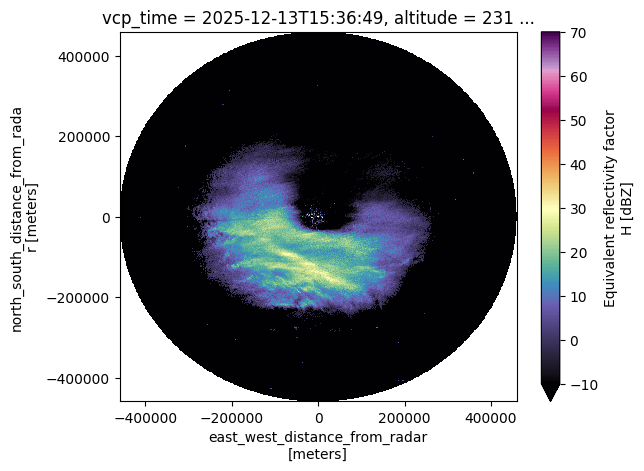

In [9]:
# Plot reflectivity from the lowest sweep of VCP-34
dtree["VCP-34/sweep_0"].DBZH.sel(vcp_time="2025-12-13 15:36", method="nearest").plot(
    x="x", 
    y="y", 
    cmap="ChaseSpectral", 
    vmin=-10, 
    vmax=70
)

## Distributed Computing with Dask

For larger analyses, we can use Dask for parallel computing. This is optional but recommended for time-series analyses.

In [10]:
from dask.distributed import LocalCluster
import hvplot.xarray

dashboard_address = "127.0.0.1:8786"
cluster = LocalCluster(dashboard_address=dashboard_address, memory_limit="10GB")
client = cluster.get_client()

## Compute Quasi-Vertical Profiles (QVP)

Quasi-Vertical Profiles are time-height plots created by azimuthally averaging radar data at high elevation angles. They're useful for studying precipitation structure and hydrometeor classification.

Here we compute QVPs for multiple polarimetric variables over a full day of data.

In [11]:
%%time
# Select a day of data from sweep_6 (higher elevation angle)
ref_qvp = dmf.compute_qvp(dtree["VCP-34/sweep_6"].sel(vcp_time="2025-12-13"), var="DBZH").compute()
zdr_qvp = dmf.compute_qvp(dtree["VCP-34/sweep_6"].sel(vcp_time="2025-12-13"), var="ZDR").compute()
rhohv_qvp = dmf.compute_qvp(dtree["VCP-34/sweep_6"].sel(vcp_time="2025-12-13"), var="RHOHV").compute()
phidp_qvp = dmf.compute_qvp(dtree["VCP-34/sweep_6"].sel(vcp_time="2025-12-13"), var="PHIDP").compute()

CPU times: user 3.81 s, sys: 322 ms, total: 4.14 s
Wall time: 12 s


### Ryzhkov-Style QVP Visualization

Create a 4-panel figure showing all polarimetric variables, following the style of Ryzhkov et al. This visualization is commonly used for hydrometeor classification and precipitation structure analysis.

CPU times: user 964 ms, sys: 47.1 ms, total: 1.01 s
Wall time: 981 ms


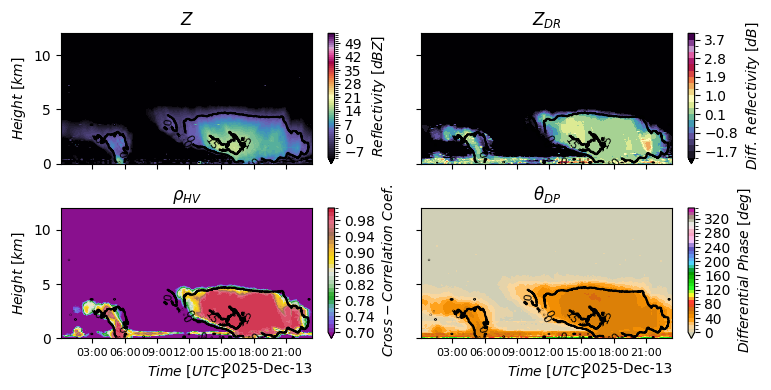

In [12]:
%%time
dmf.ryzhkov_figure(ref_qvp, zdr_qvp, rhohv_qvp, phidp_qvp)

## Quantitative Precipitation Estimation (QPE)

One of the most powerful applications of the Radar DataTree framework is **rapid precipitation accumulation** over extended time periods. Traditional workflows require downloading, decompressing, and parsing thousands of individual radar files - a process that can take hours or even days for multi-day analyses.

With Radar DataTree, we can compute **multi-day precipitation totals in seconds**.

### Snow Accumulation from the December 2025 Storm

We'll compute total precipitation from a winter storm event using the [Wolfe & Jefferson (2012)](https://journals.ametsoc.org/view/journals/apme/51/6/jamc-d-11-0112.1.xml) Z-R relationship optimized for snow:

$$Z = 110 \cdot R^2$$

This demonstrates how Radar DataTree enables **research-grade analyses** that would traditionally require significant computational infrastructure.

In [13]:
# Wolfe & Jefferson Z-R relationship 
a = 110
b = 2

In [14]:
%%time
qpe = dmf.rain_depth(dtree["VCP-34/sweep_0/DBZH"], a=a, b=b).sum("vcp_time")

Actual QPE integration period: 5 days, 2 hours, 22 minutes
Time span: 2025-12-08T21:04:51 to 2025-12-13T23:27:28 UTC
CPU times: user 17.5 ms, sys: 946 μs, total: 18.4 ms
Wall time: 17.6 ms


In [15]:
qpe

<xarray.DataArray 'rain_depth' (azimuth: 720, range: 1832)> Size: 5MB
dask.array<sum-aggregate, shape=(720, 1832), dtype=float32, chunksize=(720, 1832), chunktype=numpy.ndarray>
Coordinates:
  * azimuth    (azimuth) float64 6kB 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
  * range      (range) float32 7kB 2.125e+03 2.375e+03 ... 4.596e+05 4.599e+05
    altitude   int64 8B ...
    elevation  (azimuth) float64 6kB dask.array<chunksize=(720,), meta=np.ndarray>
    latitude   float64 8B ...
    crs_wkt    int64 8B ...
    z          (azimuth, range) float64 11MB dask.array<chunksize=(180, 458), meta=np.ndarray>
    time       (azimuth) datetime64[ns] 6kB dask.array<chunksize=(720,), meta=np.ndarray>
    longitude  float64 8B ...
    y          (azimuth, range) float64 11MB dask.array<chunksize=(180, 458), meta=np.ndarray>
    x          (azimuth, range) float64 11MB dask.array<chunksize=(180, 458), meta=np.ndarray>
Attributes:
    units:          mm
    long_name:      rainfall depth
    standard_name:  rainfall_depth
    description:    Estimated rainfall depth using Z-R relationship (a=110, b=2)

CPU times: user 3.64 s, sys: 349 ms, total: 3.99 s
Wall time: 11.6 s


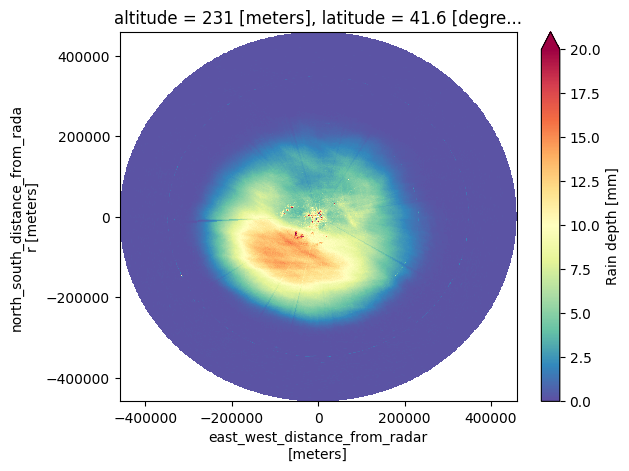

In [16]:
%%time
qpe.plot(
    x="x",
    y="y",
    vmin=0, 
    vmax=20,
    robust=True,
    cmap="Spectral_r",
    cbar_kwargs={"label": "Rain depth [mm]"},
)

### Performance Highlight

**We computed 5+ days of precipitation accumulation in ~12 seconds!**

Due to lazy evaluation, the actual computation happens when we plot (or explicitly call `.compute()`). This processed **626 volume scans** spanning December 8-13, 2025.

**Hardware**: Standard laptop at home - 4 cores, 12 threads, ~10GB RAM allocated to Dask

In a traditional workflow, this would require:
- Downloading ~626 compressed files from AWS (~2-3 GB)
- Decompressing each file individually
- Parsing proprietary binary radar format for each scan
- Loading each into memory sequentially
- Accumulating results file-by-file

**Estimated traditional processing time: 30-60+ minutes**

**Radar DataTree total time: ~12 seconds** (including data streaming from cloud)

This represents a **150-300x speedup** - transforming what was once a batch job into interactive, exploratory analysis on commodity hardware.

## Summary

This notebook demonstrated the **transformative potential** of the Radar DataTree framework using nothing more than a **standard laptop at home** (4 cores, 12 threads).

### What We Accomplished

| Analysis | Data Volume | Total Time (compute + plot) |
|----------|-------------|----------------------------|
| Load 92 GB dataset metadata | 626 volume scans | **~1.5 seconds** |
| Compute & plot QVPs (4 variables, 1 day) | ~140 scans | **~13 seconds** |
| Compute & plot QPE (5+ days) | 626 volume scans | **~12 seconds** |

*Note: Due to lazy evaluation, actual computation occurs when plotting or calling `.compute()`*

### Key Capabilities Demonstrated

1. **Sub-second metadata access**: Opened ~92 GB of radar data instantly
2. **Hierarchical navigation**: Seamlessly accessed VCP/sweep structure
3. **Time-based slicing**: Selected arbitrary time ranges with simple syntax
4. **Rapid QVP computation**: Generated 4 polarimetric profiles for a full day in ~13 seconds
5. **Multi-day QPE**: Accumulated 5+ days of precipitation in ~12 seconds

### The Radar DataTree Advantage

| Traditional Workflow | Radar DataTree |
|---------------------|----------------|
| Download thousands of files | Stream on-demand from cloud |
| Hours of preprocessing | **Seconds** to results |
| Requires HPC cluster | Runs on a **laptop at home** |
| Limited to local storage | Access petabyte-scale archives |
| Sequential file parsing | Parallel, lazy evaluation |
| Research-grade = weeks of setup | Research-grade = **immediate** |

### Unlocking New Science

The Radar DataTree framework enables analyses that were previously impractical:
- **Climate-scale radar studies**: Process years of data interactively
- **Real-time research**: Analyze ongoing events as data streams in
- **Democratized access**: No HPC required - run on your laptop
- **Reproducible science**: Version-controlled datasets with full provenance
- **Collaborative analysis**: Share cloud-hosted archives without data transfer

---

### Need to Convert Your Own Data?

If you need to convert radar data to this ARCO format, please contact:

- **Alfonso Ladino-Rincón**: https://github.com/aladinor

### Learn More

- **Paper**: [arXiv:2510.24943](https://doi.org/10.48550/arXiv.2510.24943)
- **Framework**: Built on [xarray](https://xarray.dev), [xradar](https://xradar.dev), [Zarr](https://zarr.dev), and [Icechunk](https://icechunk.io)